# 4章 拡散モデル

## 事前準備

In [1]:
!curl -L -o genaibook.zip https://github.com/oreilly-japan/hands-on-generative-ai-ja/releases/download/genaibook/genaibook.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  4678  100  4678    0     0   9435      0 --:--:-- --:--:-- --:--:--  9435


In [2]:
!unzip genaibook.zip

Archive:  genaibook.zip
Made with MacWinZipper (http://tidajapan.com/macwinzipper)
  inflating: genaibook/__init__.py   
  inflating: genaibook/core.py       


In [3]:
!pip install evaluate jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 114.3 MB/s eta 0:00:00


In [4]:
!pip install datasets==4.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 60.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


## 重要な着想：反復的精緻化

In [5]:
import datasets
import diffusers
import huggingface_hub

datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.


  0%|          | 0/1000 [00:00<?, ?it/s]

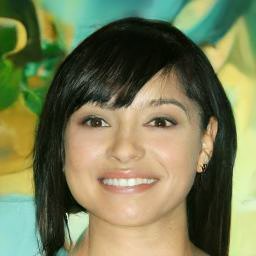

In [6]:
import torch
from diffusers import DDPMPipeline

from genaibook.core import get_device

# GPUとCPUのいずれを使用するかデバイスに設定する
device = get_device()

# パイプラインを読み込む
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

# 画像をサンプリングする
image_pipe().images[0]

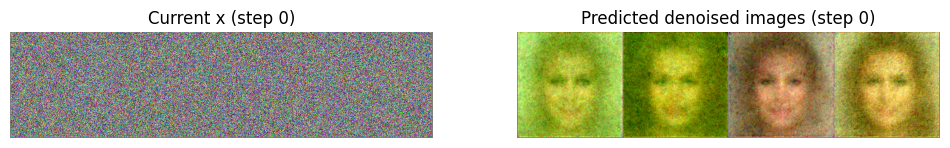

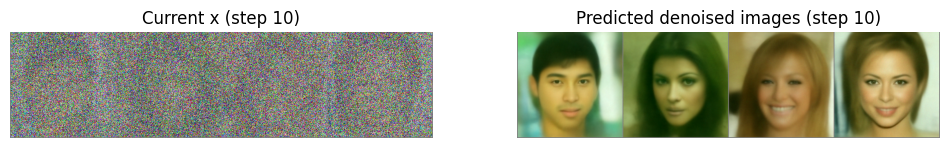

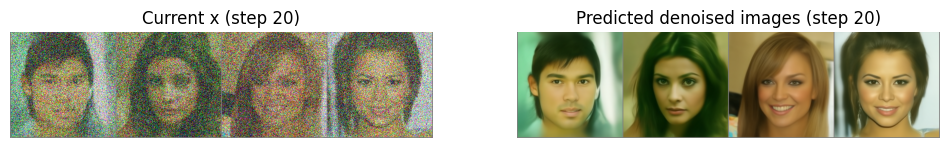

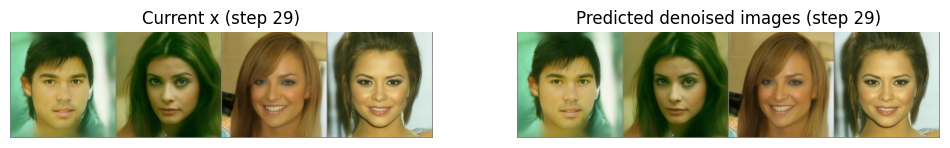

In [7]:
from genaibook.core import plot_noise_and_denoise

# ランダムな初期値として4枚の画像バッチを用いる
# 各画像は3チャンネル（RGB）、256×256ピクセルの画像である
image = torch.randn(4, 3, 256, 256).to(device)

# 拡散ステップ数を指定する
image_pipe.scheduler.set_timesteps(num_inference_steps=30)

# サンプリングのタイムステップを繰り返す
for i, t in enumerate(image_pipe.scheduler.timesteps):
    # 現在のサンプルxとタイムステップtをもとに予測値を得る
    # 推論中であるため勾配を計算する必要はないので、
    # torch.inference_mode()を用いる。
    with torch.inference_mode():
        # モデルが現在どのタイムステップにいるかを把握できるように、
        # タイムステップtを渡す。この詳細については後ほど解説する。
        noise_pred = image_pipe.unet(image, t)["sample"]

    # スケジューラーで更新後のxを計算する
    scheduler_output = image_pipe.scheduler.step(noise_pred, t, image)

    # xを更新する
    image = scheduler_output.prev_sample

    # xと予測したノイズ除去後の画像の両方を一定回数ごとに表示する
    if i % 10 == 0 or i == len(image_pipe.scheduler.timesteps) - 1:
        plot_noise_and_denoise(scheduler_output, i)

## 拡散モデルの訓練

### データ

In [8]:
from datasets import load_dataset

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
from torchvision import transforms

# 可視化のために本書よりも高めに設定している
image_size = 384

# 変換を定義する
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # リサイズする
        transforms.RandomHorizontalFlip(),  # ランダムに反転させる（データオーグメンテーション）
        transforms.ToTensor(),  # テンソル形式 (0, 1) に変換する
        transforms.Normalize([0.5], [0.5]),  # (-1, 1)の範囲になるように正規化する
    ]
)

In [10]:
def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}


dataset.set_transform(transform)
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

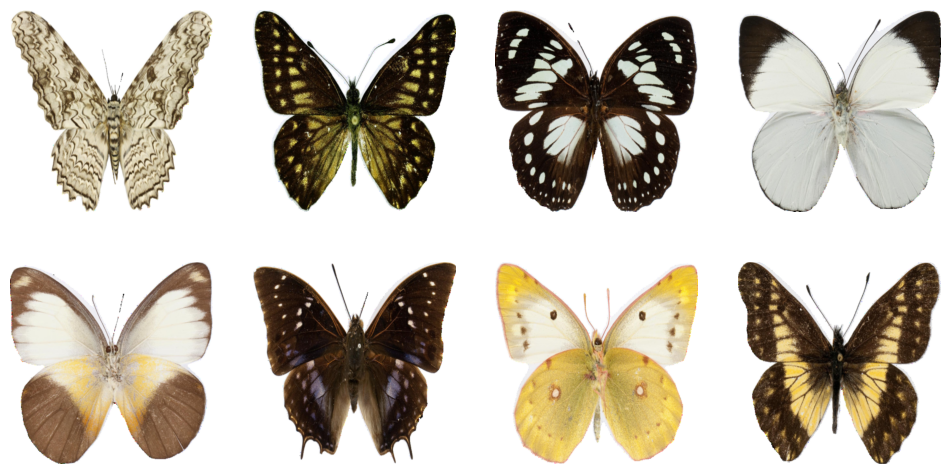

In [11]:
from genaibook.core import show_images

batch = next(iter(train_dataloader))

# 正規化時に(0, 1)を(-1, 1)に変換したが
# ここで表示のために、(0, 1)に戻す
show_images(batch["images"][:8] * 0.5 + 0.5)

### ノイズの付加

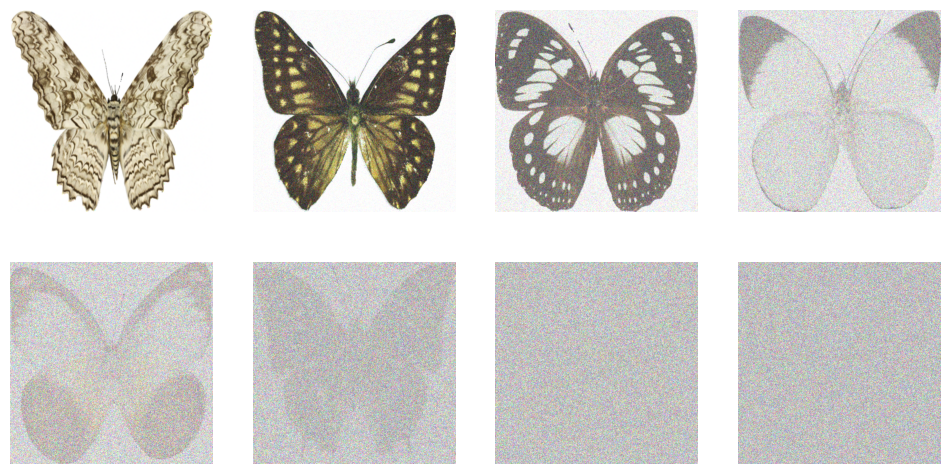

In [12]:
from diffusers import DDPMScheduler

# beta_startとbeta_endについては次節で説明する
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)

# 0から999までを等間隔で8分割した値からなるテンソルを作成する
timesteps = torch.linspace(0, 999, 8).long()

# データセットから8枚の画像を読み込み、それぞれに
# ノイズを徐々に加えていく
x = batch["images"][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

### UNet

In [13]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=3,  # RGB画像なのでチャンネル数は3
    sample_size=64,  # 入力サイズを指定
    # 各ブロックのチャンネル数はモデルの規模に影響する
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

# バッチデータを渡して動作を確認する
with torch.inference_mode():
    out = model(noised_x.to(device), timestep=timesteps.to(device)).sample

print(noised_x.shape)
print(out.shape)

torch.Size([8, 3, 384, 384])
torch.Size([8, 3, 384, 384])


### 訓練

In [14]:
from torchvision import transforms

batch_size = 32

def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}

# 初期サイズを64に戻す
dataset.set_transform(transform)
image_size = 64

# 変換を定義する
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # リサイズする
        transforms.RandomHorizontalFlip(),  # ランダムに反転させる（データオーグメンテーション）
        transforms.ToTensor(),  # テンソル形式 (0, 1) に変換する
        transforms.Normalize([0.5], [0.5]),  # (-1, 1)の範囲になるように正規化する
    ]
)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

In [15]:
from torch.nn import functional as F

num_epochs = 50  # データ全体を何回繰り返して訓練するか
lr = 1e-4  # 学習率
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []  # 後で表示するために損失を保存しておくリスト

# モデルを訓練する（しばらく時間がかかる）
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # 入力画像を読み込む
        clean_images = batch["images"].to(device)

        # 画像に加えるノイズをサンプリングする
        noise = torch.randn(clean_images.shape).to(device)

        # 各画像ごとにランダムなタイムステップをサンプリングする
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=device,
        ).long()

        # タイムステップごとのノイズ量に従って
        # 画像にノイズを加える
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # ノイズに対するモデルの予測値を得る
        # モデルには、追加の条件付けとしてタイムステップも
        # 引数に渡す
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # 予測値と実際のノイズを比較する
        loss = F.mse_loss(noise_pred, noise)

        # 後で表示できるように損失を保存する
        losses.append(loss.item())

        # この損失に基づきモデルのパラメーターを更新する
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    # このエポックの損失の平均を表示する
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(
        f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}"
    )

Finished epoch 0. Average loss for this epoch: 0.437443
Finished epoch 1. Average loss for this epoch: 0.116662
Finished epoch 2. Average loss for this epoch: 0.091941
Finished epoch 3. Average loss for this epoch: 0.073585
Finished epoch 4. Average loss for this epoch: 0.060479
Finished epoch 5. Average loss for this epoch: 0.052825
Finished epoch 6. Average loss for this epoch: 0.048201
Finished epoch 7. Average loss for this epoch: 0.041139
Finished epoch 8. Average loss for this epoch: 0.039031
Finished epoch 9. Average loss for this epoch: 0.036027
Finished epoch 10. Average loss for this epoch: 0.034604
Finished epoch 11. Average loss for this epoch: 0.035737
Finished epoch 12. Average loss for this epoch: 0.033410
Finished epoch 13. Average loss for this epoch: 0.029247
Finished epoch 14. Average loss for this epoch: 0.029328
Finished epoch 15. Average loss for this epoch: 0.029031
Finished epoch 16. Average loss for this epoch: 0.029223
Finished epoch 17. Average loss for this 

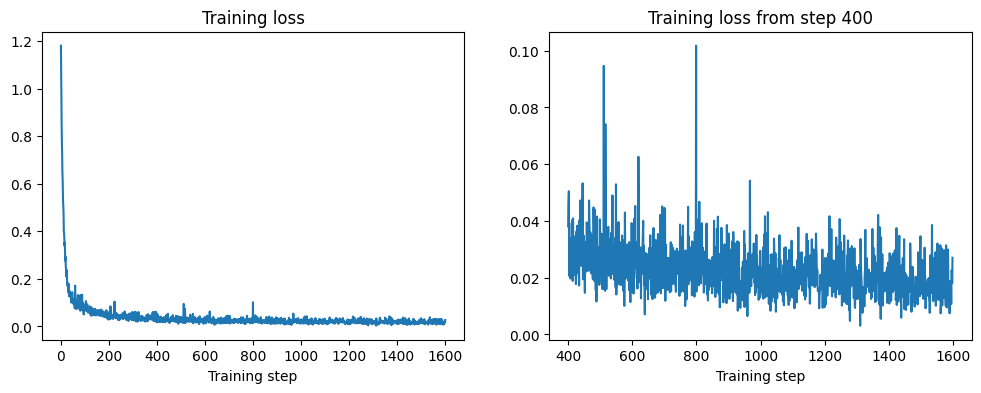

In [16]:
from matplotlib import pyplot as plt

plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")

plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step");

### サンプリング

  0%|          | 0/1000 [00:00<?, ?it/s]

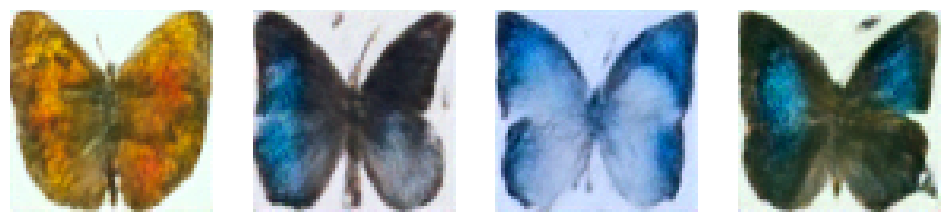

In [17]:
pipeline = DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=4).images
show_images(ims, nrows=1)

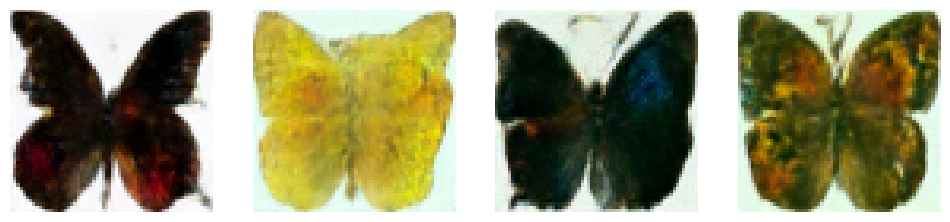

In [18]:
# ランダムな初期値（4枚のランダムな画像）
sample = torch.randn(4, 3, 64, 64).to(device)

for t in scheduler.timesteps:
    # モデルによる予測値を得る
    with torch.inference_mode():
        noise_pred = model(sample, t)["sample"]

    # ステップごとにサンプルを更新する
    sample = scheduler.step(noise_pred, t, sample).prev_sample

show_images(sample.clip(-1, 1) * 0.5 + 0.5, nrows=1)

## 詳解：ノイズスケジュール

### シンプルな実装から


In [19]:
x = next(iter(train_dataloader))["images"][:8]
noise = torch.rand_like(x)

In [20]:
def corrupt(x, noise, amount):
    # amount が元のデータに適合するように、形状を変更する。
    amount = amount.view(-1, 1, 1, 1)

    # 指定したamountに基づき、元データとノイズを混合する
    return (
        x * (1 - amount) + noise * amount
    )  # これは x.lerp(noise, amount) と同等の処理になる

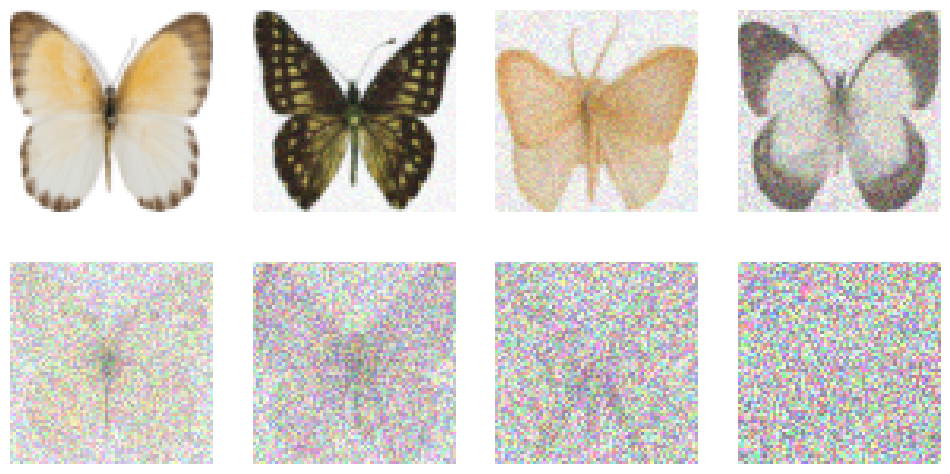

In [21]:
amount = torch.linspace(0, 1, 8)
noised_x = corrupt(x, noise, amount)
show_images(noised_x * 0.5 + 0.5)

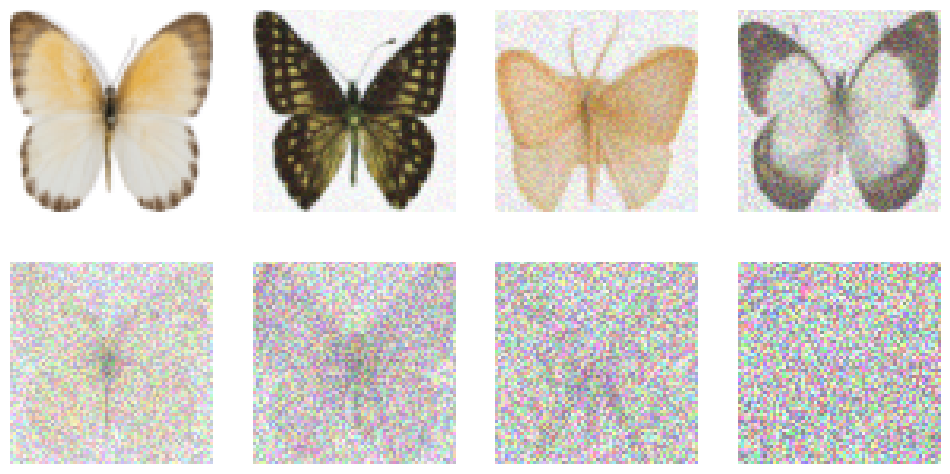

In [22]:
class SimpleScheduler:
    def __init__(self):
        self.num_train_timesteps = 1000

    def add_noise(self, x, noise, timesteps):
        amount = timesteps / self.num_train_timesteps
        return corrupt(x, noise, amount)


scheduler = SimpleScheduler()
timesteps = torch.linspace(0, 999, 8).long()
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images(noised_x * 0.5 + 0.5)

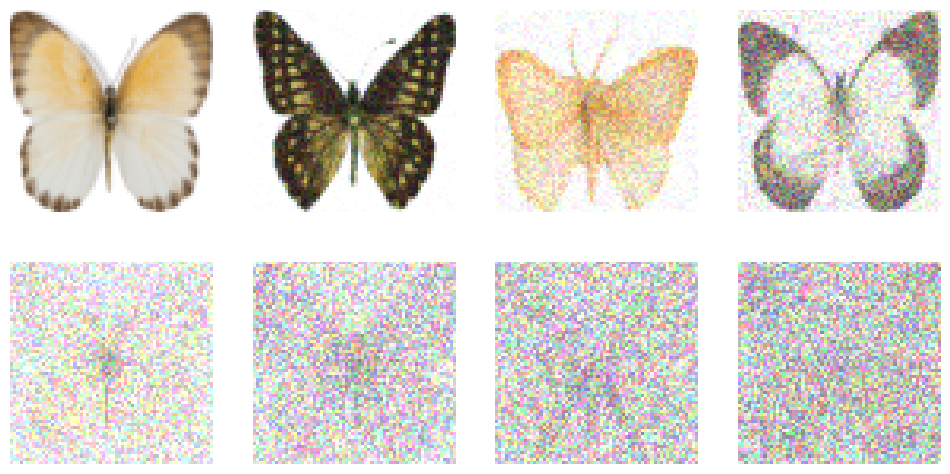

In [23]:
scheduler = DDPMScheduler(beta_end=0.01)
timesteps = torch.linspace(0, 999, 8).long()
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

### 数学的な背景

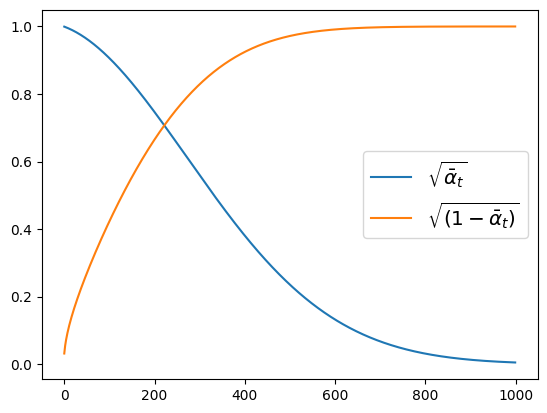

In [24]:
from genaibook.core import plot_scheduler

plot_scheduler(
    DDPMScheduler(beta_start=0.001, beta_end=0.02, beta_schedule="linear")
)

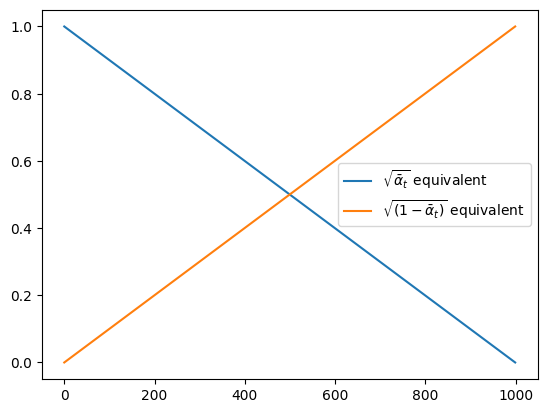

In [25]:
plot_scheduler(SimpleScheduler())

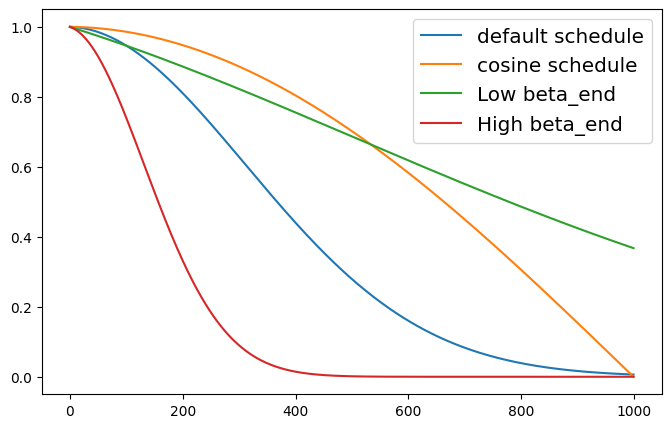

In [26]:
fig, (ax) = plt.subplots(1, 1, figsize=(8, 5))
plot_scheduler(
    DDPMScheduler(beta_schedule="linear"),
    label="default schedule",
    ax=ax,
    plot_both=False,
)
plot_scheduler(
    DDPMScheduler(beta_schedule="squaredcos_cap_v2"),
    label="cosine schedule",
    ax=ax,
    plot_both=False,
)
plot_scheduler(
    DDPMScheduler(beta_start=0.001, beta_end=0.003, beta_schedule="linear"),
    label="Low beta_end",
    ax=ax,
    plot_both=False,
)
plot_scheduler(
    DDPMScheduler(beta_start=0.001, beta_end=0.1, beta_schedule="linear"),
    label="High beta_end",
    ax=ax,
    plot_both=False,
)

### 入力解像度とスケーリングの影響

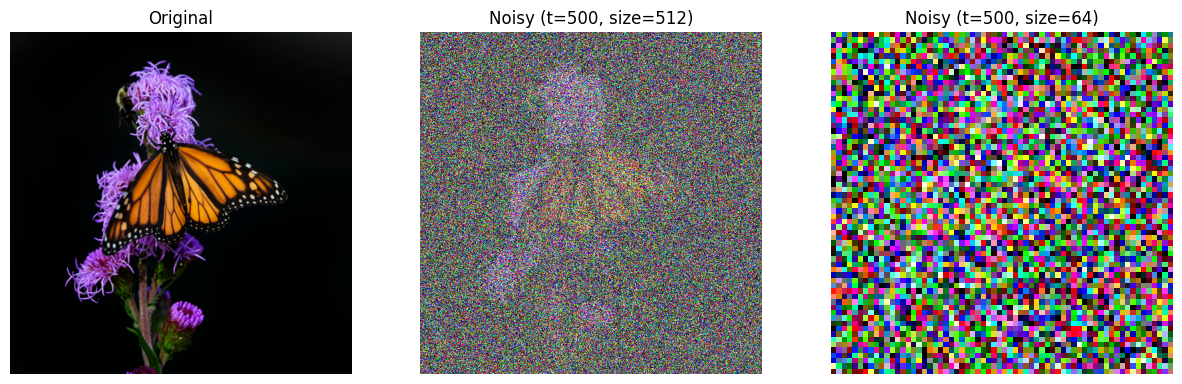

In [27]:
from genaibook.core import load_image

scheduler = DDPMScheduler(beta_end=0.05, beta_schedule="scaled_linear")
image = load_image(
    "https://images.pexels.com/photos/15403949/pexels-photo-15403949.jpeg",
    size=((512, 512)),
    return_tensor=True,
)
small_image = transforms.functional.resize(image, 64, antialias=True)
t = torch.tensor(500)  # ノイズを加えるタイムステップ
show_images(
    [
        image,
        scheduler.add_noise(image * 2 - 1, torch.randn_like(image), t).clip(
            -1, 1
        )
        * 0.5
        + 0.5,
        scheduler.add_noise(
            small_image * 2 - 1, torch.randn_like(small_image), t
        ).clip(-1, 1)
        * 0.5
        + 0.5,
    ],
    titles=["Original", "Noisy (t=500, size=512)", "Noisy (t=500, size=64)"],
    figsize=(15, 5),
)

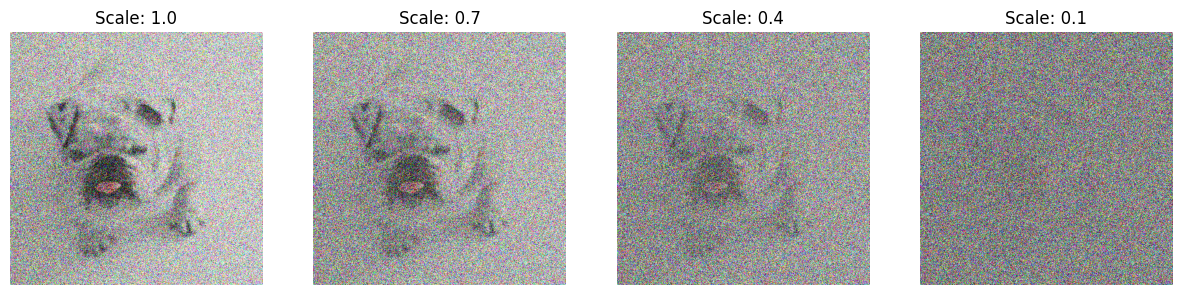

In [28]:
import numpy as np
from genaibook.core import SampleURL

scheduler = DDPMScheduler(beta_end=0.05, beta_schedule="scaled_linear")
image = load_image(
    SampleURL.DogExample,
    size=((512, 512)),
    return_tensor=True,
)

t = torch.tensor(300)  # ノイズを加えるタイムステップ
scales = np.linspace(0.1, 1.0, 4)

images = [image]
noise = torch.randn_like(image)
for b in reversed(scales):
    noised = (
        scheduler.add_noise(b * (image * 2 - 1), noise, t).clip(-1, 1) * 0.5
        + 0.5
    )
    images.append(noised)

show_images(
    images[1:],
    nrows=1,
    titles=[f"Scale: {b}" for b in reversed(scales)],
    figsize=(15, 5),
)

## 詳解：Unetとその派生モデル

### シンプルなUNet

In [29]:
from torch import nn


class BasicUNet(nn.Module):
    """最小限のUNetの実装"""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )

        # SiLU活性化関数を使用する。これはその滑らかさや非単調性などの特性があり、
        # うまく動作することがわかっている。
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:  # 3つ目（最後）のダウンサンプリング層以外で実行する
                h.append(x)  # スキップ接続用に出力を保存する
                x = self.downscale(x)  # 次の層のためにダウンサンプリングする

        for i, l in enumerate(self.up_layers):
            if i > 0:  # 最初のアップサンプリング層以外で実行する
                x = self.upscale(x)  # アップサンプリングする
                x += h.pop()  # 保存しておいた出力（スキップ接続）を取り出して加算する
            x = self.act(l(x))

        return x

この追加セクションでは、非条件拡散モデルを訓練する。今回は[MNIST](https://huggingface.co/datasets/mnist)と呼ばれる小さなデータセットを用いる。これは28×28ピクセルの手書き数字（白黒画像）が7万枚含まれるデータセットである。このデータセットに似た数字の画像を生成できる拡散モデルを訓練する。まずは`シンプルなUNet`の節で説明したカスタムUNetを用いて訓練する。

### データの探索

`datasets`ライブラリを使ってデータを読み込む。

In [30]:
from datasets import load_dataset

dataset = load_dataset("mnist")

README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

画像が想定どおりのサイズであることを確認し、本書と同じくいくつかの画像を可視化してデータの感触をつかむ。数字画像なので反転すると意味がないため、ランダムに反転はさせない。ピクセルの値は0〜1の範囲を用いる。


In [31]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

image_size = 32
batch_size = 8


def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}


dataset.set_transform(transform)

# データオーグメンテーションを定義する
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # リサイズする
        transforms.ToTensor(),  # テンソルを (0, 1) に変換する
    ]
)

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

Input shape: torch.Size([8, 1, 32, 32])


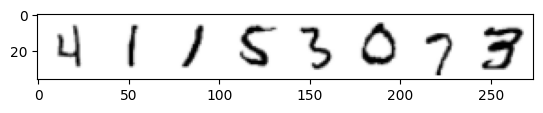

In [32]:
import torchvision
from matplotlib import pyplot as plt

imgs = next(iter(train_dataloader))["images"]
print("Input shape:", imgs.shape)
plt.imshow(torchvision.utils.make_grid(imgs)[0], cmap="Greys");

### 破損

入力画像に任意の量のノイズを加える関数を実装する。本書中で扱った内容と同じものだ。

In [33]:
def corrupt(x, noise, amount):
    amount = amount.view(-1, 1, 1, 1)
    return (
        x * (1 - amount) + noise * amount
    )  # これは x.lerp(noise, amount) と同等の処理になる

画像にノイズを加えた際の効果を可視化してみる。

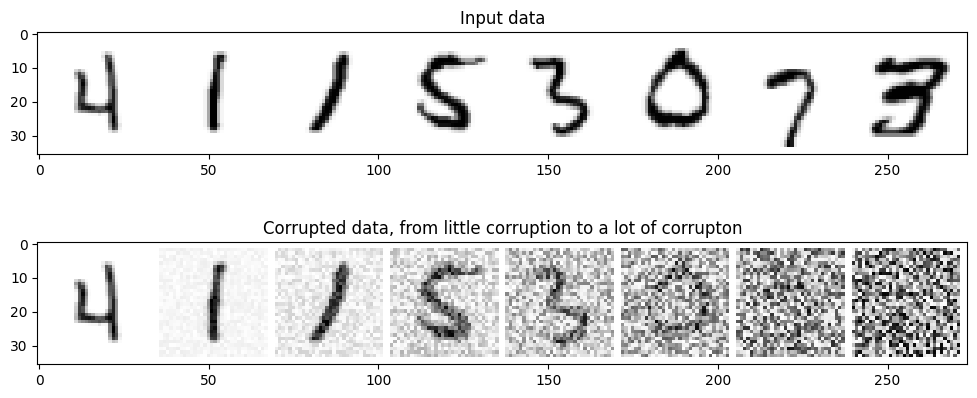

In [34]:
# 入力データを表示する。
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(imgs)[0], cmap="Greys")

# ノイズを加える（ノイズが少ないものから多いものまで）
amount = torch.linspace(0, 1, imgs.shape[0])
noise = torch.rand_like(imgs)
noised_x = corrupt(imgs, noise, amount)

# ノイズが加えられた画像を表示する。
axs[1].set_title("Corrupted data, from little corruption to a lot of corrupton")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

### 基本的なUNet

本書で紹介した最小限のUNetをまず利用する（冒頭に実装あり）。このUNetの特徴は以下の通りである。

* グレースケール画像などの1チャンネル画像に対応している。
* ダウンサンプリングおよびアップサンプリングの経路があり、それぞれ3層から構成される。
* 各層は畳み込みと活性化関数（`nn.SiLU`）からなり、その後ダウンサンプリングやアップサンプリングが続く。ただし、ダウンサンプリングの最終層やアップサンプリングの最初の層ではスケーリング処理を行わない。
* ダウンサンプリングとアップサンプリングの各ブロックの間にスキップ接続がある。

出力の形状が入力と同じであることを確認する。

In [35]:
net = BasicUNet()
x = torch.rand(8, 1, 32, 32)
net(x).shape

torch.Size([8, 1, 32, 32])

### モデルの訓練

訓練の手順をおさらいする。各ステップで以下を実行する。

1. バッチ単位で画像を読み込む。
2. 画像にノイズを加える。
3. ノイズ入り画像をモデルに入力する。
4. 損失を計算する。
5. 損失を逆伝播し、重みを更新する。

In [36]:
from torch.nn import functional as F

device = get_device()
num_epochs = 5  # データ全体を何回繰り返して訓練するか
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

model = BasicUNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []  # 後で表示するために損失を保存しておくリスト

# モデルを訓練する
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # 入力画像を読み込む
        clean_images = batch["images"].to(device)

        # 画像に加えるノイズをサンプリングする
        noise = torch.rand_like(clean_images).to(device)

        # 本書中ではtimestepを渡せるようノイズスケジューラーを
        # 使って管理していたが、ここではシンプルに、画像ごとに
        # ランダムな量のノイズを加えるだけにしている。
        noise_amount = torch.randn(clean_images.shape[0]).to(device)

        # ノイズの量に応じて画像にノイズを加える
        noisy_x = corrupt(clean_images, noise, noise_amount)

        # モデルの予測を得る
        pred = model(noisy_x)

        # 予測値と実際の画像を比較する。
        # 注意：本書中では、生成画像とノイズとの差を小さくするように
        # 最適化しており、ノイズを予測するようにモデルを訓練する。
        # ここでは画像と生成画像の損失を計算しているので、
        # 直接画像を生成するようにモデルを訓練する。
        loss = F.mse_loss(pred, clean_images)

        # この損失に基づきモデルのパラメーターを更新する
        opt.zero_grad()
        loss.backward()
        opt.step()

        # 後で表示できるように損失を保存する
        losses.append(loss.item())

    # このエポックの損失の平均を表示する
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(
        f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}"
    )

Finished epoch 0. Average loss for this epoch: 0.014916
Finished epoch 1. Average loss for this epoch: 0.009963
Finished epoch 2. Average loss for this epoch: 0.009184
Finished epoch 3. Average loss for this epoch: 0.008780
Finished epoch 4. Average loss for this epoch: 0.008649


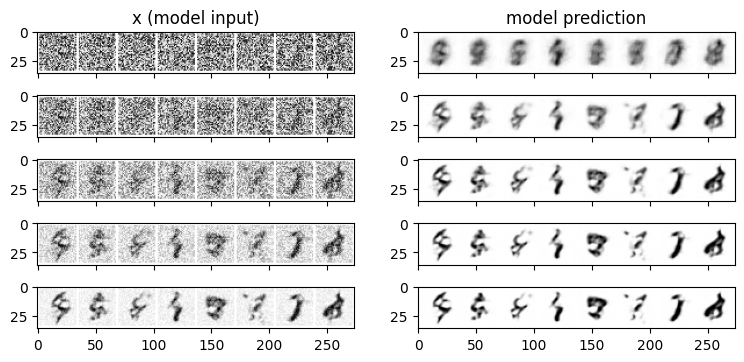

In [37]:
n_steps = 5
x = torch.rand(8, 1, 32, 32).to(device)  # ランダムな値から開始する
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    # ノイズを除去した画像を予測する
    with torch.no_grad():
        pred = model(x)

    # 表示用に出力を保存する
    pred_output_history.append(pred.detach().cpu())

    # 少しだけ移動する
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

    # 表示用に出力を保存する
    step_history.append(x.detach().cpu())

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(
        torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys"
    )
    axs[i, 1].imshow(
        torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1),
        cmap="Greys",
    )

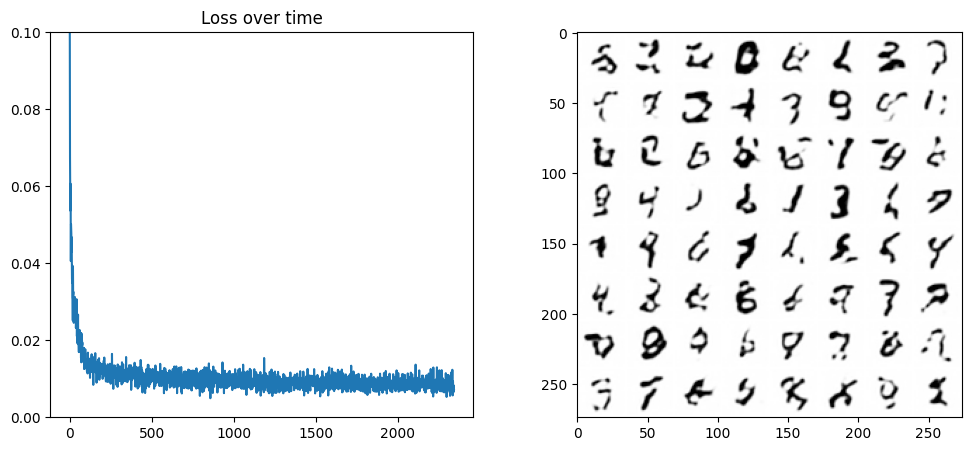

In [38]:
import torchvision
from matplotlib import pyplot as plt

# 損失とサンプルを表示する
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 損失
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

# サンプル
n_steps = 40
x = torch.rand(64, 1, 32, 32).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # ノイズ量を徐々に下げていく
    with torch.no_grad():
        pred = model(x)
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
axs[1].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1),
    cmap="Greys",
);

In [39]:
basic_losses = losses
basic_model = model

この段階では、生成される画像の品質はあまりよいとは言えない。何か改善する方法はないだろうか。

### diffusersライブラリのUNet

続いて、`diffusers`ライブラリのUNet実装を利用する。こちらは次のような拡張が含まれている。

* パラメーターの増加（各ブロックに2つの畳み込み層を持つなど）
* バッチ正規化の導入により、より高速に安定して訓練できる
* セルフアテンション層を導入し、画像内のさまざまな部分に注目できる

In [40]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,  # UNetブロックで使用するResNet層の数
    block_out_channels=(32, 64, 64),  # 基本的なUNetの例に概ね合わせる
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
).to(device)

In [41]:
sum(
    [p.numel() for p in model.parameters()]
)  # 1.7M（170万）パラメーター。基本的なUNetの約30万9千パラメーターと比較して多い。

1707009

このモデルは大きくなっているため、訓練にもより時間がかかる。

In [42]:
batch_size = 128
train_dataloader = DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)
num_epochs = 5

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []  # 後で表示するために損失を保存しておくリスト

# モデルを訓練する
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # 入力画像を読み込む
        clean_images = batch["images"].to(device)

        # 画像に加えるノイズをサンプリングする
        noise = torch.rand_like(clean_images).to(device)

        # 画像に加えるノイズ量をサンプリングする
        noise_amount = torch.randn(clean_images.shape[0]).to(device)

        # ノイズ量に応じて入力画像にノイズを加える
        noisy_x = corrupt(clean_images, noise, noise_amount)

        # タイムステップ0でモデルの予測を得る
        pred = model(noisy_x, 0).sample

        # 予測値と実際の画像を比較する。
        # 注意：本書中では、生成画像とノイズとの差を小さくするように
        # 最適化しており、ノイズを予測するようにモデルを訓練する。
        # ここでは画像と生成画像の損失を計算しているので、
        # 直接画像を生成するようにモデルを訓練する。
        loss = F.mse_loss(pred, clean_images)

        # この損失に基づきモデルのパラメーターを更新する
        opt.zero_grad()
        loss.backward()
        opt.step()

        # 後で表示できるように損失を保存する
        losses.append(loss.item())

    # このエポックの損失の平均を表示する
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(
        f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}"
    )

Finished epoch 0. Average loss for this epoch: 0.012871
Finished epoch 1. Average loss for this epoch: 0.007244
Finished epoch 2. Average loss for this epoch: 0.006346
Finished epoch 3. Average loss for this epoch: 0.005826
Finished epoch 4. Average loss for this epoch: 0.005430


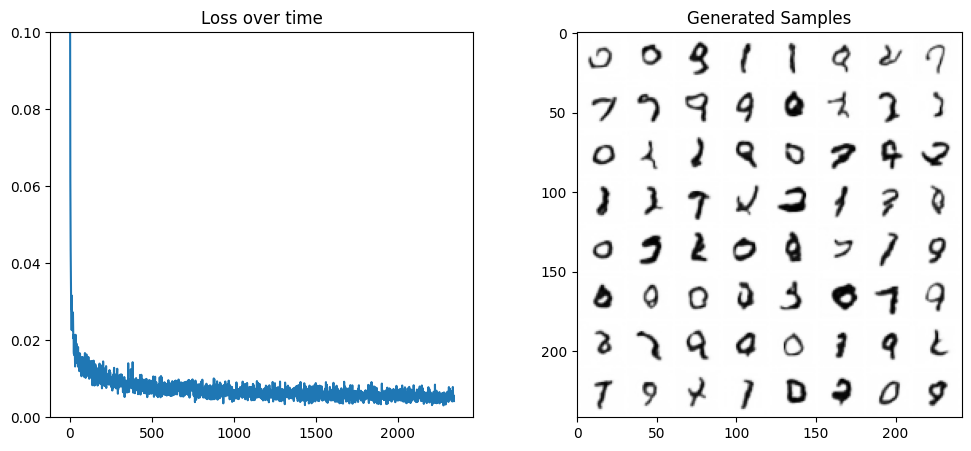

In [43]:
# 損失とサンプルを表示する
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 損失
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

# サンプル
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # ノイズ量を徐々に下げていく
    with torch.no_grad():
        pred = model(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1),
    cmap="Greys",
)
axs[1].set_title("Generated Samples");

ずっとよくなった。まだ完璧とは言えないが、手軽に訓練できるモデルとしては大きな進歩である。

前のモデルと合わせて損失の推移を表示しよう。

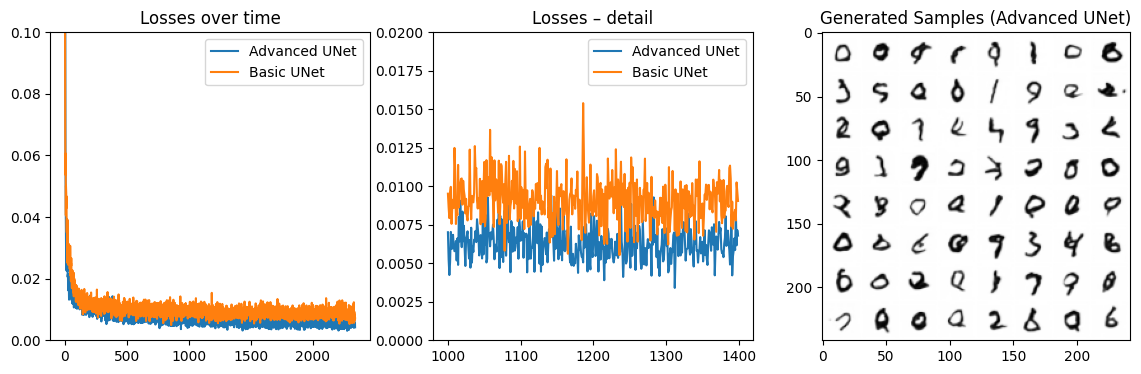

In [44]:
# 損失とサンプルを表示する
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
import numpy as np

# 損失
axs[0].plot(losses, label="Advanced UNet")
axs[0].plot(basic_losses, label="Basic UNet")
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Losses over time")
axs[0].legend()

axs[1].plot(losses[1000:1400], label="Advanced UNet")
axs[1].plot(basic_losses[1000:1400], label="Basic UNet")
axs[1].set_ylim(0, 0.02)
axs[1].set_title("Losses – detail")
axs[1].set_xticks(np.arange(0, 401, step=100), np.arange(1000, 1401, step=100))
axs[1].legend()

# サンプル
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # ノイズ量を徐々に下げていく
    with torch.no_grad():
        pred = model(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[2].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1),
    cmap="Greys",
)
axs[2].set_title("Generated Samples (Advanced UNet)");

## 詳解：拡散モデルの目的関数

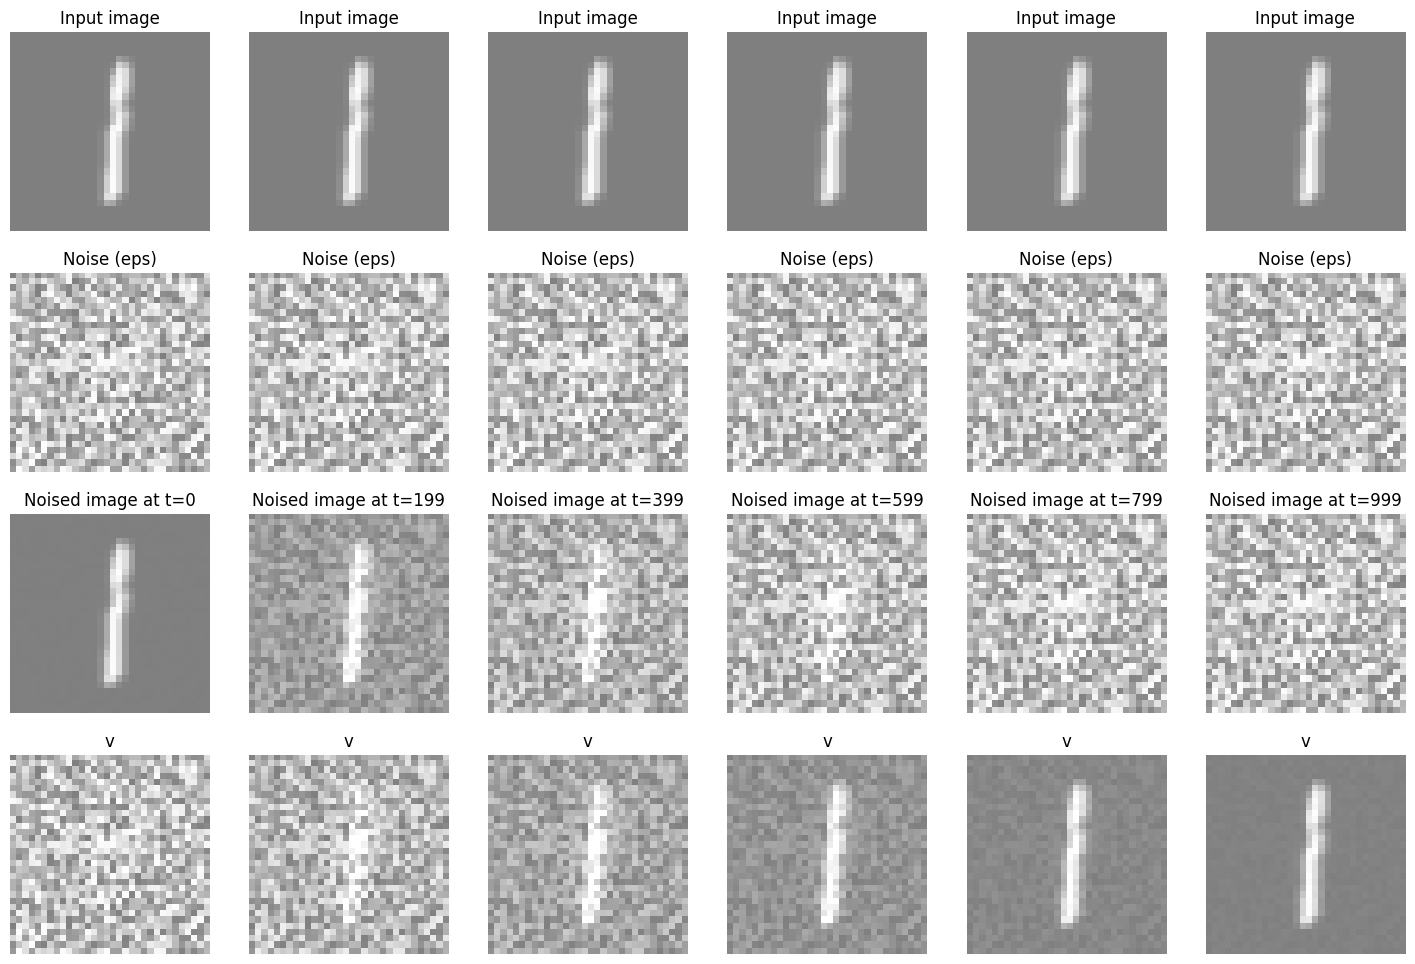

In [45]:
# 大きなサイズの画像に合わせて修正
scheduler = DDPMScheduler(beta_end=0.012)
sample = batch["images"][0]
image_size = sample.shape[-1]
noise_size = image_size  # 32
res_transform = transforms.Resize(noise_size, antialias=True)
x = res_transform(sample.expand(6, 3, image_size, image_size))
noise = torch.rand_like(res_transform(sample)).expand(
    6, 3, noise_size, noise_size
)
timesteps = torch.linspace(0, 999, 6).long()
noised_x = scheduler.add_noise(x, noise, timesteps)
alpha_bars = scheduler.alphas_cumprod[timesteps]
v = (
    alpha_bars.view(-1, 1, 1, 1).sqrt() * noise
    + (1 - alpha_bars.view(-1, 1, 1, 1)).sqrt() * x
)
images = torch.cat(
    [
        x,
        noise,
        noised_x,
        v,
    ],
    dim=0,
)
titles = (
    ["Input image"] * 6
    + ["Noise (eps)"] * 6
    + [f"Noised image at t={t}" for t in timesteps]
    + ["v"] * 6
)

show_images(images.clip(-1, 1) * 0.5 + 0.5, ncols=6, titles=titles)

## 解答



### 演習

**1. 拡散推論アルゴリズムについて説明せよ。**

拡散モデルによる推論アルゴリズムは、ランダムノイズから開始し、段階的にノイズを除去してサンプルを生成するアルゴリズムである。拡散の手順は以下の通りである。

1. ターゲットデータと同じ形状のランダムなサンプルから始める。
2. 拡散プロセスの各ステップごとに次の処理を実行する
    1. 現在のサンプルに含まれるノイズを予測する。
    2. ノイズスケジュールに従い、予測されたノイズを少しずつ除去することでサンプルを更新する。

実際には、タイムステップをモデルへのパラメーターとして用いてノイズを予測する。最初はノイズレベルが高く、ステップを進めるごとに徐々にノイズレベルを下げていく。

```python
# ランダムな初期値（4枚のランダムな画像）
sample = torch.randn(4, 3, 64, 64).to(device)

for t in scheduler.timesteps:
    # モデルによる予測値を得る
    with torch.no_grad():
        noise_pred = model(sample, t)["sample"]

    # スケジューラーを使って段階的にノイズを取り除く
    sample = scheduler.step(noise_pred, t, sample).prev_sample
```

**2. ノイズスケジューラーの役割は何か。**

ノイズスケジューラーは、画像にどのようにノイズを加えるかを定義するヘルパークラスである。スケジューラーは、拡散モデルの出力、サンプル、現在のタイムステップを受け取り、サンプルを更新して返却する。

**3. 画像の訓練データセットを作成する際、どのような特徴に注意すべきか。**

1. 画像のサイズ。モデルが扱えるようにするには、データと同じサイズの画像が必要である。
2. チャンネル数。たとえば、グレースケール画像は1チャンネル、RGB画像は3チャンネルである。
3. ピクセルの値の範囲。モデルはこの範囲のピクセルを扱えなければならない。
4. ランダムな反転や回転などのデータデータオーグメンテーションを適用するかどうか。

**4. 訓練画像をランダムに反転させる理由は何か。**

画像をランダムに反転させることで、データセットの多様性が高まる。水平方向や垂直方向に反転させることで、モデルはさまざまな向きの物体を学習できるようになり、より堅牢で汎用性の高いモデルになる。

**5. 拡散モデルの生成結果を評価するにはどうすればよいか。**

FIDやKIDといった指標を用いて生成結果を評価できるが、これらの指標には限界がある。人間の好み（主観的評価）が品質のゴールドスタンダードであるが、評価コストが高い。

**6. `beta_end`の値は拡散プロセスにどのような影響を与えるか。**

`beta_end`はノイズスケジューラーの終了時のノイズ量を制御する。値が高いと過程の最後に加わるノイズが増え、画像がぼやけやすくなる。値が低いとノイズが少なくなり、よりシャープな画像になる傾向がある。

**7. 拡散モデルの主流モデルとしてVAEではなくUNetが使用される理由は何か。**

VAEは低次元の潜在空間から画像を再構成する必要があり、ピクセル単位で精度の高いサンプルを生成することが難しい。一方、UNetはダウンサンプリングブロックからアップサンプリングブロックへスキップ接続で情報を直接伝達できるため、ピクセルレベルの精度と画像全体の高次情報の両方をうまく扱える。

**8. アテンション層やTransformerベースのアーキテクチャーなどのTransformer関連の技術を拡散モデルに取り入れる場合、どのような利点と課題があるか。**

Transformerは計算コストやメモリの消費量が大きく、高解像度画像へのスケールも課題となることが多い。しかし、高品質なサンプルを生成でき、FIDスコアの向上が期待できる。また、より大規模なモデルの基盤として可用性も高い。

UNetにアテンション層を追加する方法もある。セルフアテンション層を導入すると、モデルは画像のさまざまな部分に注目でき、より複雑な生成が可能になる。ただし、アテンション層は通常の畳み込み層より計算コストが高い点に注意が必要である。


### 課題

**9. 次の式**

$$
\begin{equation}
\mathbf{x}_t =  \sqrt{1 - \beta_t} \mathbf{x}_{t-1} +  \sqrt{\beta_t} \mathbf{\epsilon}
\end{equation}
$$

**と**

$$
\begin{equation}
x_t = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1-\bar{\alpha_t}}\epsilon
\end{equation}
$$

**が、等価であることを示せ。**

**この問題は簡単ではなく、拡散モデルの利用に必須な内容でもない。ヒントとしては、 [_A Beginner's Guide to Diffusion Models: Understanding the Basics and Beyond_](https://roysubhradip.hashnode.dev/a-beginners-guide-to-diffusion-models-understanding-the-basics-and-beyond) を読むことを勧める。ここで重要なのは、2つの異なる分散を持つガウス分布を合成する方法である。つまり、 $\mathcal{N}(\mu_1, \sigma_1^2)$ and $\mathcal{N}(\mu_2, \sigma_2^2)$がある場合、これを合成したガウス分布は $\mathcal{N}(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)$となる。**

まず $\alpha_t = 1 - \beta_t$ と定義する。これにより、最初の式は次のように書き換えられる。

$$
\begin{equation}
\mathbf{x}_t =  \sqrt{\alpha_t} \mathbf{x}_{t-1} +  \sqrt{{1-\alpha_t}} \mathbf{\epsilon}
\end{equation}
$$

ここで、 $\mathbf{x}_{t-1}$ を展開し

$$
\begin{equation}
\mathbf{x}_t =  \sqrt{\alpha_t} \left( \sqrt{\alpha_{t-1}} \mathbf{x}_{t-2} +  \sqrt{{1-\alpha_{t-1}}} \mathbf{\epsilon} \right) +  \sqrt{{1-\alpha_t}} \mathbf{\epsilon}
\end{equation}
$$

この式は次のように書き直せる。

$$
\begin{equation}
\mathbf{x}_t =  \sqrt{\alpha_t} \sqrt{\alpha_{t-1}} \mathbf{x}_{t-2} +  \sqrt{\alpha}_t \sqrt{{1-\alpha}_{t-1}} \mathbf{\epsilon} +  \sqrt{{1-\alpha}_t} \mathbf{\epsilon}
\end{equation}
$$


ここで、再パラメーター化のトリックのように $\bar{\alpha}_t = \Pi_{s=1}^{t} \alpha_s$ と定義する。

**10. 本章ではDDPMスケジューラーを使用したが、高品質な生成結果を得るために数百から数千のステップが必要となる場合がある。最近の研究では、極力少ないステップ数（1～2ステップなど）で高品質な生成を実現する方法が模索されている。`diffusers`ライブラリには[「Denoising Diffusion Implicit Models」論文](https://arxiv.org/abs/2010.02502)で提案されている`DDIMScheduler`などのさまざまスケジューラーが実装されている。`DDIMScheduler`を用いて画像を生成してみよう。本章のサンプリングの節では、`DDPMScheduler`を使い1,000ステップを必要としたが、`DDIMScheduler`でこれと同等の品質の画像が生成できるようになるまでに何ステップ必要だろうか。`google/ddpm-celebahq-256`モデルのスケジューラーを切り替えて試し、両者を比較しよう。**

50ステップだけで生成を行う。

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.


  0%|          | 0/50 [00:00<?, ?it/s]

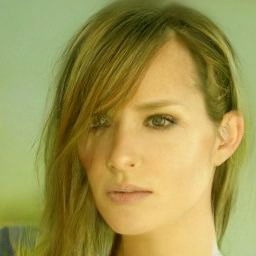

In [46]:
from diffusers import DDIMPipeline

# GPUとCPUのいずれを使用するかデバイスに設定する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# パイプラインを読み込む
image_pipe = DDIMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

# 画像をサンプリングする
image_pipe().images[0]